In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_pickle("immusign/immusign_not_normalized_with_out_of_frame_merged_raw_data_cleaned_olga_pgen.pkl")

In [4]:
df = df[df.bestVGene.apply(lambda x: "IGH" in x)].copy()

In [7]:
embeddings = np.load("aa_cdr3_embeddings.npy")

In [8]:
with open("sorted_index_aa_cdr3.txt", "r") as file:
    indx = [int(line.strip()) for line in file]

In [9]:
embeddings.shape

(3015432, 320)

In [19]:
b = {"dlbcl" : ["dlbcl_1", "dlbcl_2", "dlbcl_3"]}
list(b.keys())

['dlbcl']

In [10]:
emb_Series = pd.Series(list(embeddings), index = indx)

In [11]:
emb_Series

490911     [-0.035199735313653946, -0.40712404251098633, ...
928286     [-0.011515339836478233, -0.1602695882320404, 0...
2331508    [0.07461756467819214, -0.3007756471633911, 0.3...
2116561    [0.07644666731357574, -0.24223890900611877, 0....
2873765    [-0.03712927922606468, -0.2712849974632263, 0....
                                 ...                        
1228685    [0.22848033905029297, -0.6120370626449585, 0.3...
1200382    [0.1784563660621643, -0.47329482436180115, 0.2...
1228349    [0.14060892164707184, -0.5106889605522156, 0.1...
920947     [0.1475306749343872, -0.3870342969894409, 0.14...
1199882    [0.16787230968475342, -0.5873712301254272, 0.1...
Length: 3015432, dtype: object

In [12]:
df["esm_embedding"] = emb_Series

In [13]:
df.columns

Index(['Read.count', 'Read.proportion', 'CDR3.nucleotide.sequence',
       'CDR3.amino.acid.sequence', 'V.gene', 'J.gene', 'D.gene', 'V.end',
       'J.start', 'D5.end', 'D3.end', 'VD.insertions', 'DJ.insertions',
       'Total.insertions', 'sample', 'cloneId', 'clones.txt.name',
       '#Nucleotide clones', '#Aminoacid clonotypes', '%Aminoacid clonotypes',
       '#In-frames', '%In-frames', '#Out-of-frames', '%Out-of-frames',
       'Sum.reads', 'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Clonality', 'twb.shannon', 'twb.simp',
       'pcr_target_locus', 'organism', 'template', 'tissue', 'lymphoma_type',
       'lymphoma_specification', 'subject_id', 'sex', 'dosc', 'age', 'dob',
       'cloneCount', 'cloneFraction', 'aaSeqCDR3', 'bestVGene', 'bestDGene',
       'bestJGene', 'vBestIdentityPercent', 'lengthOfCDR3', 'targetSequences',
       'allVGenes', 'allDGenes', 'allJGenes', 'allVHits', 'allDHits',
       'allJHits', 'allVAlignments

In [14]:
#df.to_pickle("immusign/immusign_not_normalized_with_out_of_frame_merged_raw_data_cleaned_olga_pgen_embeddings_igh.pkl")

In [11]:
embedded_df = pd.DataFrame(columns=["clones.txt.name", "lymphoma_specification", "sum_rep_embedding", "mean_rep_embedding"])
for i, group in df.groupby("clones.txt.name"): 
    sum_rep_embedding = sum(group.cloneCount * group.esm_embedding)
    mean_rep_embedding = np.mean(group.cloneCount * group.esm_embedding)
    embedded_df.loc[len(embedded_df)] = [i, group.lymphoma_specification.iloc[0], sum_rep_embedding, mean_rep_embedding]

In [24]:
cloneFraction = []
for name, group in df.groupby("clones.txt.name"):
    cloneFraction.append(group['cloneFraction'].values[0])

In [33]:
from run_embedding_classification import load_data
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

In [34]:
comparisons = [['nlphl'], ["dlbcl", "gcb_dlbcl", "abc_dlbcl"], ['hd']]
X, y, clone_fraction = load_data(comparisons, dict(embedding_method = "sum", standardize=True))
    
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
train_index, test_index =  sss.split(X, y).__next__()

In [44]:
y_test = y[test_index]
clone_fractions_test = clone_fraction[test_index]

In [45]:
low_cf = np.array([1 if ((clone_fractions_test[i] < 0.2) & (y_test[i] == 1)) else 0 for i in range(len(y_test))])

In [46]:
low_cf

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [42]:
cloneFraction = []
for name, group in df.sort_values(["clones.txt.name", "cloneFraction"], ascending= [True, False]).groupby("clones.txt.name"):
    cloneFraction.append(group['cloneFraction'].values[0])

In [43]:
cloneFraction[-1]

0.945342886386899

In [13]:
embedded_df.mean_rep_embedding

0      [-5.1116039277146905, -29.137987727117547, 23....
1      [-0.2723304237522835, -1.5325474960537375, 1.0...
2      [-1.3149673660833432, -6.072691107484191, 3.99...
3      [-0.16132844263844306, -0.8450560320630321, 0....
4      [-5.784918720465211, -16.96502570461249, 13.70...
                             ...                        
946    [-1.850489331969237, -9.623783821055655, 6.860...
947    [-0.7415266025494346, -5.490423128809423, 3.87...
948    [-0.9697154581567277, -5.217679438721445, 3.64...
949    [-122.75003280341514, 380.4147959887272, -360....
950    [-5.244017513644506, 3.5301658865881334, 14.40...
Name: mean_rep_embedding, Length: 951, dtype: object

In [14]:
embedded_df.iloc[0].mean_rep_embedding.shape

(320,)

In [17]:
df.lymphoma_specification.unique()

array(['hd', 'gcb_dlbcl', 'cll', 'unspecified', 'dlbcl', 'nlphl',
       'abc_dlbcl', 'thrlbcl', 'lymphadenitis'], dtype=object)

In [18]:
import utils
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import torch
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [19]:
comparisons = [['nlphl'], ["dlbcl", "gcb_dlbcl", "abc_dlbcl"], ['hd']]
comparison_labels = ['nlphl', 'dlbcl', 'hd']

In [27]:
X = embedded_df[embedded_df.lymphoma_specification.isin(sum(comparisons,[]))]

In [29]:
X.loc[:, "lymphoma_specification_grouped"] = X["lymphoma_specification"].apply(lambda x: "dlbcl" if x in comparisons[1] else x)

/var/folders/lj/8f2m9cts7c1_dl0lwj330pyr0000gq/T/ipykernel_12077/416818564.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, "lymphoma_specification_grouped"] = X["lymphoma_specification"].apply(lambda x: "dlbcl" if x in comparisons[1] else x)


In [30]:
X

,clones.txt.name,lymphoma_specification,sum_rep_embedding,mean_rep_embedding,lymphoma_specification_grouped
0,101-D0-Ig-gDNA-PB-Nuray-A250_S240.clones.txt,hd,"[-996.7627659043646, -5681.907606787921, 4671....","[-5.1116039277146905, -29.137987727117547, 23....",hd
1,101-D28-Ig-gDNA-PB-Nuray-A250_S190.clones.txt,hd,"[-1099.3979206879685, -6186.894241568938, 4243...","[-0.2723304237522835, -1.5325474960537375, 1.0...",hd
2,105-D0-Ig-gDNA-PB-Nuray-A250_S179.clones.txt,hd,"[-3454.4192707009424, -15952.95953936097, 1049...","[-1.3149673660833432, -6.072691107484191, 3.99...",hd
3,105-D14-Ig-gDNA-human-Nuray_S59.clones.txt,hd,"[-587.8808449744865, -3079.384180837689, 2222....","[-0.16132844263844306, -0.8450560320630321, 0....",hd
4,105-D28-Ig-gDNA-PB-Nuray-A250_S180.clones.txt,hd,"[-3470.951232279127, -10179.015422767494, 8223...","[-5.784918720465211, -16.96502570461249, 13.70...",hd
...,...,...,...,...,...
905,Nils-hs-IGHFR3-ABC-DLBCL025-Tumor-DNA_S123.clo...,abc_dlbcl,"[1961.7858209034894, -3991.7462378870696, -273...","[56.05102345438541, -114.04989251105913, -78.2...",dlbcl
906,Nils-hs-IGHFR3-ABC-DLBCL026-Tumor-DNA_S163.clo...,abc_dlbcl,"[-1731.6538629457355, -4002.3668360710144, 114...","[-288.6089771576226, -667.0611393451691, 190.9...",dlbcl
946,Svenja-IGH-HD121-28-10-2020_S161.clones.txt,hd,"[-4109.936806303675, -21374.42386656461, 15237...","[-1.850489331969237, -9.623783821055655, 6.860...",hd
947,Svenja-IGH-HD128_S162.clones.txt,hd,"[-1196.8239365147874, -8861.542929898409, 6252...","[-0.7415266025494346, -5.490423128809423, 3.87...",hd


In [31]:
X, labels = utils.encode_target_for_classification(X, "lymphoma_specification_grouped")

In [32]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
train_index, test_index =  sss.split(X, X["lymphoma_specification_grouped"]).__next__()

In [33]:
Y_train = np.asarray(list(X.iloc[train_index]["lymphoma_specification_grouped_encoded"]))
Y_test = np.asarray(list(X.iloc[test_index]["lymphoma_specification_grouped_encoded"]))

In [35]:
X_test = X.iloc[test_index].copy()
X_test_sum = np.concatenate(list(X_test["sum_rep_embedding"].apply(lambda x: x.reshape((1,-1)))))
X_test_mean = np.concatenate(list(X_test["mean_rep_embedding"].apply(lambda x: x.reshape((1,-1)))))
X_train = X.iloc[train_index].copy()
X_train_sum = np.concatenate(list(X_train["sum_rep_embedding"].apply(lambda x: x.reshape((1,-1)))))
X_train_mean = np.concatenate(list(X_train["mean_rep_embedding"].apply(lambda x: x.reshape((1,-1)))))

sum_means = np.mean(X_train_sum, axis=0)
mean_means = np.mean(X_train_mean, axis=0)
sum_stds = np.std(X_train_sum, axis=0)
mean_stds = np.std(X_train_mean, axis=0)

In [88]:
X_train_sum_normalized = (X_train_sum-sum_means)/sum_stds
X_test_sum_normalized = (X_test_sum-sum_means)/sum_stds

In [89]:
X_train_mean_normalized = (X_train_mean-mean_means)/mean_stds
X_test_mean_normalized = (X_test_mean-mean_means)/mean_stds

In [37]:
X.columns

Index(['lymphoma_specification_grouped_encoded', 'clones.txt.name',
       'lymphoma_specification', 'sum_rep_embedding', 'mean_rep_embedding',
       'lymphoma_specification_grouped'],
      dtype='object')

# Standard Classification

In [102]:
model = SVC(kernel='linear', max_iter=100000000)
#model = LogisticRegression(max_iter=1000)
#model = RandomForestClassifier(n_estimators=100, max_depth=16)

In [103]:
model.fit(X_train_sum_normalized,Y_train)

SVC(kernel='linear', max_iter=100000000)

In [104]:
Y_pred = model.predict(X_test_sum_normalized)

In [93]:
print("Mean Repertoire Embedding")
print(classification_report(Y_test, Y_pred,target_names=labels))

Mean Repertoire Embedding
              precision    recall  f1-score   support

       dlbcl       0.86      0.67      0.75        18
          hd       0.78      1.00      0.87        31
       nlphl       0.50      0.22      0.31         9

    accuracy                           0.78        58
   macro avg       0.71      0.63      0.64        58
weighted avg       0.76      0.78      0.75        58



In [97]:
print("Mean Normalized Repertoire Embedding")
print(classification_report(Y_test, Y_pred,target_names=labels))

Mean Normalized Repertoire Embedding
              precision    recall  f1-score   support

       dlbcl       1.00      0.28      0.43        18
          hd       0.58      1.00      0.74        31
       nlphl       0.00      0.00      0.00         9

    accuracy                           0.62        58
   macro avg       0.53      0.43      0.39        58
weighted avg       0.62      0.62      0.53        58



/Users/labadmin/anaconda3/envs/bonn17/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/labadmin/anaconda3/envs/bonn17/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/labadmin/anaconda3/envs/bonn17/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [101]:
print("Sum Repertoire Embedding")
print(classification_report(Y_test, Y_pred,target_names=labels))

Sum Repertoire Embedding
              precision    recall  f1-score   support

       dlbcl       0.77      0.56      0.65        18
          hd       0.85      0.90      0.88        31
       nlphl       0.42      0.56      0.48         9

    accuracy                           0.74        58
   macro avg       0.68      0.67      0.67        58
weighted avg       0.76      0.74      0.74        58



In [105]:
print("Sum Normalized Repertoire Embedding")
print(classification_report(Y_test, Y_pred,target_names=labels))

Sum Normalized Repertoire Embedding
              precision    recall  f1-score   support

       dlbcl       0.70      0.78      0.74        18
          hd       0.88      0.90      0.89        31
       nlphl       0.50      0.33      0.40         9

    accuracy                           0.78        58
   macro avg       0.69      0.67      0.68        58
weighted avg       0.76      0.78      0.77        58



In [44]:
import umap

In [50]:
embeddings = np.concatenate(list(X["rep_embedding"].apply(lambda x: x.reshape((1,-1)))))
#means = np.mean(embeddings, axis=0)
#stds = np.std(embeddings, axis=0)
#embeddings = (embeddings-means)/stds


lymphoma_labels = np.asarray(list(X["lymphoma_specification_grouped_encoded"]))
X_embedded_umap = umap.UMAP(n_components=2).fit_transform(embeddings)

In [46]:
labels

['dlbcl', 'hd', 'nlphl']

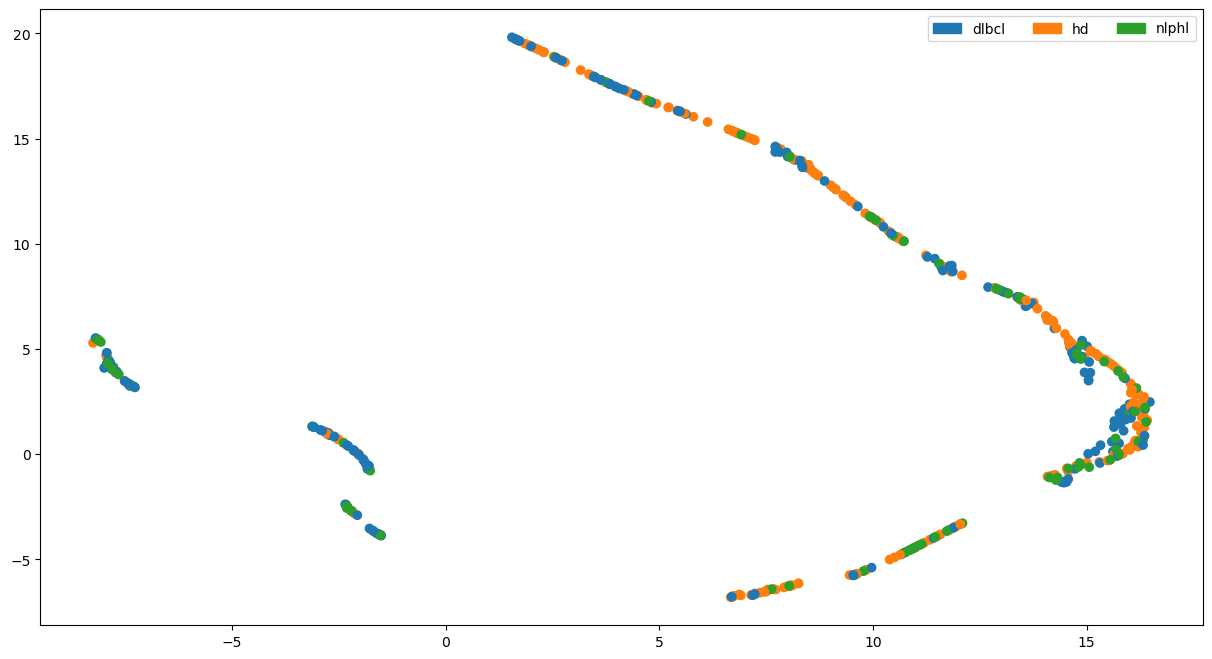

In [51]:
%matplotlib inline
#%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

colors= ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9"]
c=[]
for y in lymphoma_labels:
    c.append(colors[y])
"""
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_embedded_umap[:,0], X_embedded_umap[:,1], X_embedded_umap[:,2], c=c)    
"""
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(X_embedded_umap[:,0], X_embedded_umap[:,1], c=c)

handles = []
for i in range(len(labels)):
    handles.append(mpatches.Patch(color=colors[i], label=labels[i]))
ax.legend(handles=handles, ncols=3)


# ANN Classification

In [106]:
from tqdm import tqdm
import torch

In [119]:
import model_zoo
import matplotlib.pyplot as plt

In [160]:
model = model_zoo.NonLinearModel(input_channel = 320, output_channel=3, hidden_units=1280, hidden_layers=3 ,global_average_pooling=False)

In [176]:
model = model_zoo.ResnetModel(input_channel = 320, output_channel=3, hidden_units=1280,hidden_layers=3, global_average_pooling=False)

In [177]:
device = torch.device("cpu")
model.to(device)

ResnetModel(
  (activation_function): LeakyReLU(negative_slope=0.01)
  (resid_layers): ModuleList(
    (0): Linear(in_features=320, out_features=1280, bias=True)
    (1-2): 2 x Linear(in_features=1280, out_features=1280, bias=True)
  )
  (output_layer): Linear(in_features=1280, out_features=3, bias=True)
)

In [178]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(),lr=0.000001)
criterion = torch.nn.CrossEntropyLoss()

In [179]:
for g in optimizer.param_groups:
    print(g['lr'])
    #g['lr'] = 1e-06
    print(g['lr'])

1e-06
1e-06


In [180]:
from torch.utils.data import DataLoader, TensorDataset

In [181]:
# Assuming X_df is your input features DataFrame and y_df is your target labels DataFrame
#X_train_tensor = torch.tensor(np.expand_dims(X_train,axis=1), dtype=torch.float32).to(device)
X_train_tensor = torch.tensor(X_train_mean_normalized, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test_mean_normalized, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).to(device)

In [182]:
dataset = TensorDataset(X_train_tensor, y_train_tensor)

In [183]:
batch_size = 8  # Adjust the batch size according to your needs
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
N_EPOCHS = 1000

In [184]:
epoch_loss = []
for i in tqdm(range(N_EPOCHS), desc ='Training...'):
    average_epoch_loss = []
    
    running_loss = 0.0

    for batch_x, batch_y in dataloader:
        #epoch_loss = []
    
        #epoch_acc = []
        
        Y_hat = model(batch_x)
        optimizer.zero_grad() # set gradients to zero before performing backprop
        targets = torch.tensor(utils.one_hot_from_label(batch_y.cpu().numpy().astype(int), n_classes=3)).to(device, dtype=torch.float32)
        loss = criterion(Y_hat, targets)
        
        average_epoch_loss += [loss.item()]
        
        running_loss += loss.item()
        loss.backward()  # compute dloss/dx and accumulated into x.grad
        optimizer.step()  # compute x += -learning_rate * x.grad

    
    epoch_loss += [np.mean(average_epoch_loss)]

Training...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:45<00:00,  1.21it/s]


In [22]:
len(b)

2

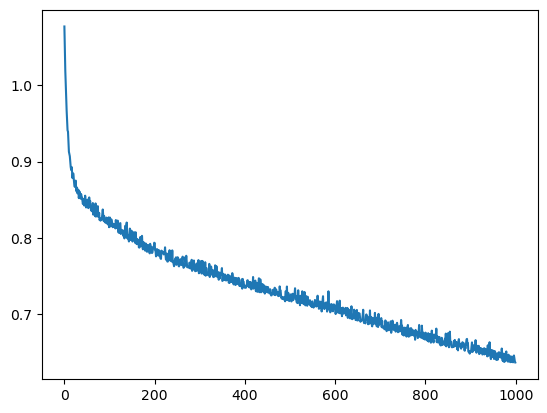

In [185]:
fig, ax = plt.subplots()
ax.plot(range(len(epoch_loss )), epoch_loss)

In [186]:
test_loss = []
pred_labels = []
true_labels = []
for i in tqdm(range(len(X_test_tensor))):
    x = X_test_tensor[i:i+1]
    y = y_test_tensor[i:i+1]
    y = torch.tensor(utils.one_hot_from_label(y.cpu().numpy().astype(int), n_classes=3))
    with torch.no_grad():
        Y_hat = model(x)
        loss = criterion(Y_hat.cpu(), y)
        Y_hat = torch.nn.functional.softmax(Y_hat, dim=1)
    
    pred_labels += [np.argmax(Y_hat.detach().cpu().numpy(),axis=1)]
    true_labels += [np.argmax(y.detach().cpu().numpy())]
    test_loss += [loss.item()]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 703.45it/s]


In [ ]:
print()

In [136]:
print("Sum Repertoire Embedding")
print(classification_report(true_labels, pred_labels, target_names=labels))

Sum Repertoire Embedding
              precision    recall  f1-score   support

       dlbcl       0.93      0.72      0.81        18
          hd       0.74      1.00      0.85        31
       nlphl       0.50      0.11      0.18         9

    accuracy                           0.78        58
   macro avg       0.72      0.61      0.61        58
weighted avg       0.76      0.78      0.73        58



In [159]:
print("Sum Normalized Repertoire Embedding")
print(classification_report(true_labels, pred_labels, target_names=labels))

Sum Normalized Repertoire Embedding
              precision    recall  f1-score   support

       dlbcl       0.74      0.94      0.83        18
          hd       0.87      0.87      0.87        31
       nlphl       0.75      0.33      0.46         9

    accuracy                           0.81        58
   macro avg       0.79      0.72      0.72        58
weighted avg       0.81      0.81      0.79        58



In [175]:
print("Mean Repertoire Embedding")
print(classification_report(true_labels, pred_labels, target_names=labels))

Mean Repertoire Embedding
              precision    recall  f1-score   support

       dlbcl       0.79      0.83      0.81        18
          hd       0.81      0.94      0.87        31
       nlphl       0.67      0.22      0.33         9

    accuracy                           0.79        58
   macro avg       0.75      0.66      0.67        58
weighted avg       0.78      0.79      0.77        58



In [187]:
print("Mean Normalized Repertoire Embedding")
print(classification_report(true_labels, pred_labels, target_names=labels))

Mean Normalized Repertoire Embedding
              precision    recall  f1-score   support

       dlbcl       0.79      0.61      0.69        18
          hd       0.66      0.94      0.77        31
       nlphl       0.00      0.00      0.00         9

    accuracy                           0.69        58
   macro avg       0.48      0.52      0.49        58
weighted avg       0.60      0.69      0.63        58



/Users/labadmin/anaconda3/envs/bonn17/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/labadmin/anaconda3/envs/bonn17/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/labadmin/anaconda3/envs/bonn17/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [456]:
df_rep_size = df.groupby("clones.txt.name").apply(len).reset_index().sort_values(by=0)

In [457]:
df_rep_size

,clones.txt.name,0
584,LisaP-IGH-CLL-P20082-1_S140.clones.txt,1
850,NC-hs-IGH-CLL177-pb_S37.clones.txt,1
673,LisaS-hs-FR3-DLBCL39_S105.clones.txt,1
532,Jenny-hs-IGH-CLL093-PB-gDNA_S48.clones.txt,1
531,Jenny-hs-IGH-CLL062-PB-gDNA_S39.clones.txt,1
...,...,...
742,LisaS-hs-FR3-NLPHL-HD-Lymphadenitis-5_S164.clo...,20999
733,LisaS-hs-FR3-NLPHL-38-ED_S116.clones.txt,21246
415,Dona-hs-FR3IGH-K259-10-Tumor-Erstdiagnose-gDNA...,22486
412,Dona-hs-FR3IGH-H14197-10-Tumor-Rezidiv1-gDNA_S...,25347


In [469]:
np.unique(df_rep_size[0], return_counts=True)

(array([    1,     2,     3,     4,     5,     6,     7,     8,     9,
           10,    11,    12,    13,    14,    15,    16,    17,    18,
           19,    20,    21,    22,    23,    24,    25,    26,    27,
           28,    29,    30,    31,    32,    33,    34,    35,    36,
           37,    38,    39,    40,    41,    42,    44,    45,    46,
           47,    48,    49,    50,    51,    52,    53,    54,    55,
           56,    57,    58,    59,    60,    61,    62,    63,    65,
           67,    68,    72,    74,    77,    78,    79,    80,    81,
           82,    83,    85,    87,    89,    90,    91,    93,    95,
           96,   100,   103,   104,   106,   108,   109,   118,   119,
          121,   122,   126,   127,   129,   132,   134,   136,   138,
          145,   148,   149,   152,   153,   156,   159,   160,   162,
          166,   168,   169,   171,   172,   174,   176,   181,   186,
          192,   195,   196,   197,   204,   210,   214,   215,   216,
      

In [463]:
df_rep_size_larger_5 = df[df["Read.count"] >5].groupby("clones.txt.name").apply(len).reset_index().sort_values(by=0)

In [464]:
df_rep_size_larger_5

,clones.txt.name,0
525,Jenny-hs-IGH-CLL093-PB-gDNA_S48.clones.txt,1
768,LisaS-hs-ighFR3-NLPHL41-Rez2-20-Ampl_S167.clon...,1
524,Jenny-hs-IGH-CLL062-PB-gDNA_S39.clones.txt,1
854,NC-hs-IGH-CLL421-pb_S54.clones.txt,1
856,NC-hs-IGH-CLL423-pb_S56.clones.txt,1
...,...,...
81,20211210-hs-IGH-BNT-7-1-CoVac-pb_S38.clones.txt,6849
423,Dona-hs-IGHFR3-K130-14-Tumor-Rezidiv-gDNA_S275...,7292
72,20211210-hs-IGH-BNT-17-1-CoVac-pb_S57.clones.txt,7304
730,LisaS-hs-FR3-NLPHL-HD-Lymphadenitis-4_S163.clo...,7831


In [468]:
np.unique(df_rep_size_larger_5[0], return_counts=True)

(array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
          12,   13,   14,   15,   16,   17,   18,   20,   21,   22,   23,
          24,   26,   27,   28,   29,   30,   31,   32,   33,   34,   35,
          36,   38,   39,   40,   41,   42,   43,   44,   45,   46,   47,
          48,   49,   52,   53,   54,   56,   57,   59,   60,   61,   62,
          64,   66,   72,   74,   78,   79,   82,   85,   88,   89,   90,
          92,   94,   98,  100,  101,  103,  104,  105,  106,  109,  110,
         112,  118,  122,  123,  125,  129,  137,  139,  141,  142,  143,
         150,  151,  152,  153,  156,  160,  167,  175,  177,  178,  182,
         184,  185,  188,  189,  196,  200,  210,  218,  220,  221,  235,
         237,  251,  253,  254,  255,  265,  273,  278,  282,  289,  292,
         293,  296,  298,  300,  304,  305,  308,  311,  316,  319,  321,
         322,  323,  330,  333,  336,  340,  343,  359,  361,  364,  370,
         372,  373,  378,  382,  391, 

In [465]:
df[df["clones.txt.name"] == "LisaP-IGH-CLL-P20082-1_S140.clones.txt"]

,Read.count,Read.proportion,CDR3.nucleotide.sequence,CDR3.amino.acid.sequence,V.gene,J.gene,D.gene,V.end,J.start,D5.end,...,aaSeqCDR2,aaSeqCDR1,aaSeqFR2,aaSeqFR3,aaSeqFR4,aaSeqImputedVDJRegion,has_mutation,olga_pgen_cdr3,olga_pgen_aa,esm_embedding
2247284,7982,1.0,TGTGCGAGGGACAGTGGGACCTACTCTCTTGACTACTGG,CARDSGTYSLDYW,"IGHV3-21, IGHV3-21, IGHV3-21, IGHV3-21, IGHV3-21","IGHJ4, IGHJ4","IGHD1-26, IGHD6-19",11,21,12,...,NaN,NaN,NaN,NaN,NaN,NaN,False,4.077528e-17,9.118636e-12,"[-0.037519533187150955, -0.2069951891899109, 0..."


In [245]:
df.groupby("clones.txt.name")["cloneCount"].apply(sum).reset_index().sort_values(by="cloneCount")

,clones.txt.name,cloneCount
125,AP-hs-IGH-CLL062-PB-gDNA_S149.clones.txt,5
375,Dona-HD036-IGH-Wiederholung_S35.clones.txt,7
613,LisaS-hs-FR3-DLBCL-KM-Inf-01_S130.clones.txt,8
673,LisaS-hs-FR3-DLBCL39_S105.clones.txt,9
780,LisaS-hs-ighFR3-NLPHL41-Rez2-20-Ampl_S167.clon...,10
...,...,...
668,LisaS-hs-FR3-DLBCL37-II_S42.clones.txt,262420
433,F10P-Ig-CLL-Simon_S166.clones.txt,269683
506,I5P-Ig-CLL-Simon_S167.clones.txt,394506
442,F4P-Ig-CLL-Simon_S163.clones.txt,477272


In [223]:
target_column = "lymphoma_specification_grouped_encoded"

In [74]:
X_test = X.iloc[test_index].copy()
X = X.iloc[train_index].copy()

In [75]:
n_folds = 5

In [76]:
skf = StratifiedKFold(n_splits=n_folds, shuffle = True, random_state = 42)

In [77]:
train_valid_folds = list(skf.split(X, X[target_column]))

In [79]:
X_train_folds = []
y_train_folds = []
X_valid_folds = []
y_valid_folds = []

for i in range(n_folds):
    
    train_folds = train_valid_folds[i][0]
    valid_folds = train_valid_folds[i][1]
    X_train = X.iloc[train_folds]
    y_train = np.asarray(X_train[target_column])
       
    X_valid = X.iloc[valid_folds]
    y_valid = np.asarray(X_valid[target_column])

In [ ]:
for i, X_train in enumerate(tqdm(X_train_folds)):
    y_train = y_train_folds[i]
    X_valid = X_valid_folds[i]
    y_valid = y_valid_folds[i]
    

In [86]:
INPUT_DIM = 320
NUM_HIDDEN_NODES =1028
NUM_OUTPUT_NODES = 3
NUM_LAYERS = 2
DROPOUT = 0.5


model = model_zoo.ResnetModel(input_channel=INPUT_DIM,output_channel=NUM_OUTPUT_NODES,hidden_layers=NUM_LAYERS,hidden_units=NUM_HIDDEN_NODES)
model.train()
device = torch.device("mps")

import torch.optim as optim
model = model.to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

BATCH_SIZE =16
N_EPOCHS = 100

In [ ]:
epoch_loss = []
epoch_acc = []
for ii in tqdm(range(N_EPOCHS), desc ='Training...',position=0,leave=True):
    average_epoch_loss = []
    average_epoch_metric = []
    average_epoch_acc = []
    
    running_loss = 0.0
    epoch = create_epoch_with_same_size_batching(length_with_index_dict, BATCH_SIZE , shuffle=True)

    for jj, idxs in enumerate(tqdm(epoch,desc = "Batch...",position=1, leave=False)): #enumerate(epoch):
        model.train()
        # index by indices in batch

        batch_input_jj = X_train.iloc[idxs]
        
        batch_input_jj_lens = torch.from_numpy(X_train_lens.iloc[idxs].values)#.to(device)
        
        batch_input = pad_batch_online(batch_input_jj_lens, batch_input_jj, style="zero")
        batch_input = torch.from_numpy(batch_input).to(device, dtype=torch.float32)

       
        Y_hat = model(batch_input, batch_input_jj_lens)

        batch_output_jj = torch.from_numpy(np.stack(Y_train.iloc[idxs].values)).to(device, dtype=torch.float32)


        optimizer.zero_grad() # set gradients to zero before performing backprop
        loss = criterion(Y_hat.squeeze(), batch_output_jj.to(torch.float32))
        average_epoch_loss += [loss.item()]
        
        #f1score = metric(Y_hat, batch_output_jj)
        #average_epoch_metric += [f1score.item()]
        
        running_loss += loss.item()
        loss.backward()  # compute dloss/dx and accumulated into x.grad
        optimizer.step()  # compute x += -learning_rate * x.grad

        model.eval()
        Y_hat = model(batch_input, batch_input_jj_lens)
        Y_hat = torch.nn.functional.softmax(Y_hat, dim=1)
        
        pred_labels = np.argmax(Y_hat.detach().cpu().numpy(),axis=1)
        true_labels = np.argmax(batch_output_jj.detach().cpu().numpy(), axis=1)
        
        acc = np.mean(pred_labels == true_labels)
        average_epoch_acc += [acc]
    
    epoch_loss += [np.mean(average_epoch_loss)]
    epoch_acc += [np.mean(average_epoch_acc)]
    #print("Avg Training Loss: " + str(np.mean(average_epoch_loss)) + "\n" +
    #      #"Avg Training Score: " + str(np.mean(average_epoch_metric)) + "\n" +
    #      "Running Training Loss: " + str(float(running_loss)))
    #time.sleep(0.1)
    